# Predicción de sueldo

El objetivo de este proyecto es poder estimar el sueldo de una persona basandonos en las respuestas obtenidas por las encuestas de sysarmy.

El texto apunta a que cualquier persona, sin necesariamente tenre conocimento técnico de programación o estadística, pueda leerlo.

## Las encuestas

Sysarmy efectúa dos veces por año desde hace varios semestres unas encuestas de sueldo con muchas respuestas en Argentina. Armaremos modelos de Machine Learning que puedan usar esa información para poder predecir sueldos de otra persona, una herramienta muy útil para la gente que busca trabajo.

Tengamos en cuenta que los datos de estas encuestas no son completamente confiables por varios motivos. Por un lado, la gente que responde está autoseleccionada, es decir que no necesariamente se una muestra representativa de la población. Sólo gente que se enteró de la encuesta y tuvo la suficiente voluntad de completarla lo hizo. Esto puede hacer que personas que tengan más conexiones se hayan enterado y gente que no es tan activa en la comunidad no, por ejemplo, y las primeras quizás tienen más oportunidades laborales.

Otro posible problema es que no hay validación alguna sobre los datos o la gente que responde. Podrían haber usuarios maliciosos completando información incorrecta adrede, por ejemplo empresas que quieren bajar las expectativas salariales del mercado. También hay gente que responde incorrectamente por no haber leído bien la consigna.

Un último inconveniente a señalar es lo dispar que pueden ser las formas de comprender una pregunta. Por ejemplo al ingresar el salario uno elige si es neto o bruto, pero algunos rubros pueden tener subsidios o ingresos no remunerativos que generan confusión al momento de responder.

Sin embargo, la encuesta tiene una cantidad de respuestas significativa y no hay motivos para creer que haya distorciones intencionales, por lo que los datos son interesantes de analizar aunque debemos tener cierta cautela al momento de tomar conclusiones.

## Sobre mí

Trabajo como programador desde 2006 pero estoy incursionado en el campo de Machine Learning desde hace poco, por lo que no me considero un experto en el tema.

## Librerías

Usaré pandas, matplotlib y scikitlearn. No voy a entrar en detalles de cómo funciona cada una porque sería demasiado largo y tedioso.

In [1]:
%matplotlib inline 
import pandas as pd

df = pd.read_csv('Encuesta de remuneración salarial de sysarmy - 2018.1 - Argentina.csv', skiprows=3)

Ahora cargamos el csv de resultados en un DataFrame (el equivalente a una matriz). Para generar un modelo de Machine Learning vamos a necesitar transformarlo en una matriz que sólo tenga valores numéricos. Empezamos graficando los datos que tenemos, esto nos va a dar una idea de los datos que existen.

In [2]:
print('\n'.join(df.columns.tolist()))

Me identifico
Tengo
Argentina
Años de experiencia
Años en el puesto actual
¿Gente a cargo?
¿Cuánta?
Nivel de estudios alcanzado
Estado
Carrera
Realizaste cursos de especialización
Trabajo de
Tecnologías que utilizás
Tecnologías que utilizás.1
Tecnologías que utilizás.2
Automation o funcional?
Tecnologías que utilizás.3
Tecnologías que utilizás.4
¿Tenés guardias?
Cuánto cobrás por guardia (en tu moneda local)
¿Porcentaje, bruto o neto?
Tipo de contrato
Salario mensual (en tu moneda local)
¿Bruto o neto?
¿Qué tan conforme estás con tu sueldo?
Cómo creés que está tu sueldo con respecto a julio 2017
Recibís algún tipo de bono
A qué está atado el bono
¿Tuviste ajustes por inflación en 2017?
¿De qué % fue el ajuste?
Cantidad de empleados
¿Cambiaste de empresa en los últimos 6 meses?
¿Cuál fue el principal motivo de cambio?
Beneficios extra


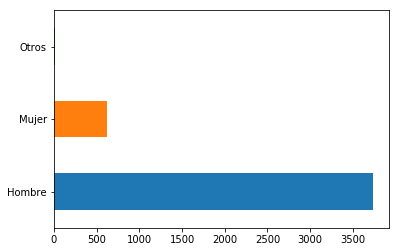

In [3]:
df['Me identifico'].value_counts().plot.barh();

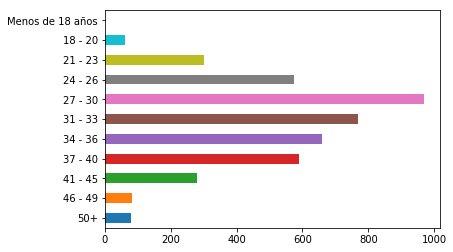

In [4]:
def plot_col(series, replace=None, **kwargs):
    replace = replace or {}
    c = pd.DataFrame(series.value_counts()).reset_index().replace(replace).sort_values(by='index', ascending=False).replace({v: k for k, v in replace.items()}).set_index('index')
    del c.index.name
    c[c.columns[0]].plot.barh(**kwargs)
plot_col(df['Tengo'], {'Menos de 18 años': '17'});

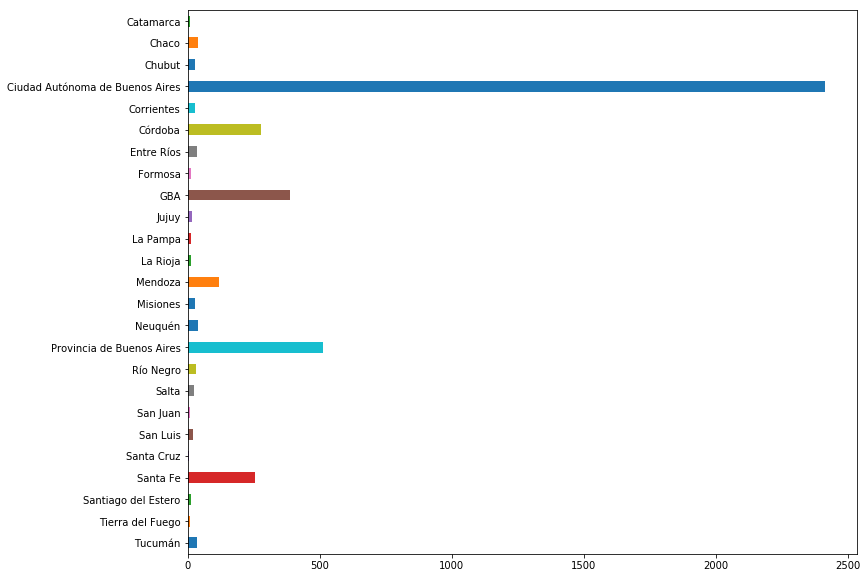

In [5]:
plot_col(df['Argentina'], figsize=(12, 10));

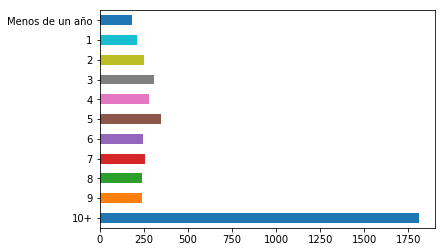

In [6]:
plot_col(df['Años de experiencia'], {'10+': '99', 'Menos de un año': '0'});

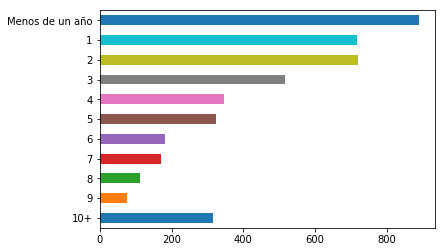

In [7]:
plot_col(df['Años en el puesto actual'], {'10+': '99', 'Menos de un año': '0'});

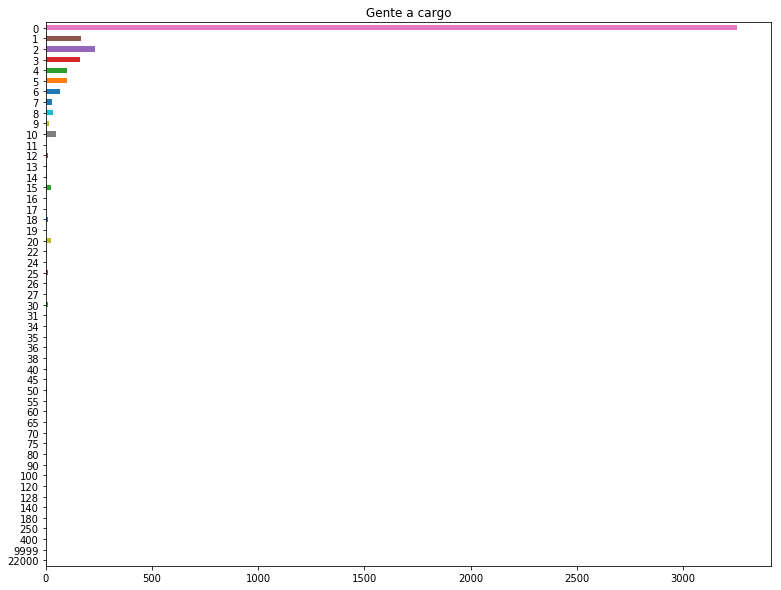

In [8]:
plot_col(df['¿Cuánta?'], title='Gente a cargo', figsize=(13, 10));

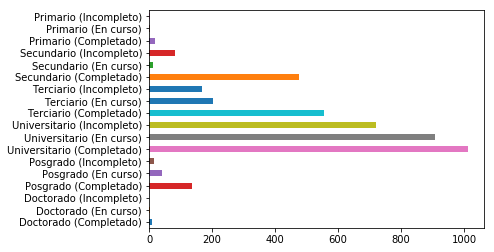

In [9]:
plot_col(df.apply(lambda x: '{} ({})'.format(x['Nivel de estudios alcanzado'], x['Estado']), axis=1), replace={
    'Primario (Incompleto)': '00',
    'Primario (En curso)': '01',
    'Primario (Completado)': '02',
    'Secundario (Incompleto)': '03',
    'Secundario (En curso)': '04',
    'Secundario (Completado)': '05',
    'Terciario (Incompleto)': '06',
    'Terciario (En curso)': '07',
    'Terciario (Completado)': '08',
    'Universitario (Incompleto)': '09',
    'Universitario (En curso)': '10',
    'Universitario (Completado)': '11',
    'Posgrado (Incompleto)': '12',
    'Posgrado (En curso)': '13',
    'Posgrado (Completado)': '14',
    'Doctorado (Incompleto)': '15',
    'Doctorado (En curso)': '16',
    'Doctorado (Completado)': '17',
});

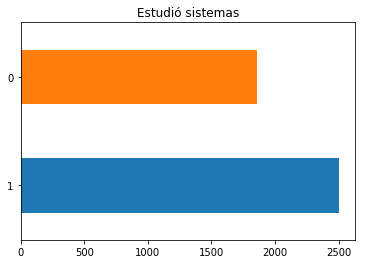

In [10]:
def is_desistemas(x):
    x = str(x).lower()
    return int('sistemas' in x or 'informática' in x or 'informatica' in x or 'computación' in x or 'computacion' in x or 'programador' in x or 'programación' in x)
df['Carrera'].map(is_desistemas).value_counts().plot.barh(title='Estudió sistemas');

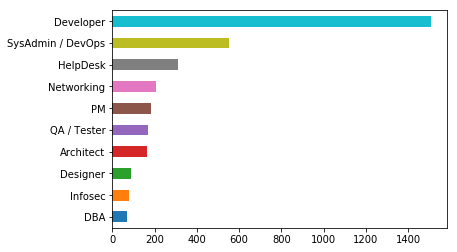

In [11]:
df['Trabajo de'].value_counts(ascending=True).tail(10).plot.barh();

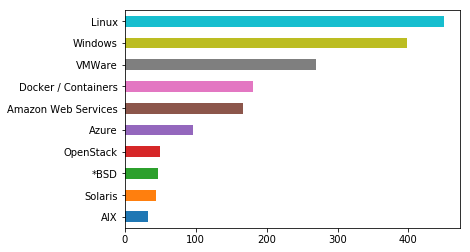

In [12]:
tech_count = {}
for x in df['Tecnologías que utilizás'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(10).plot.barh();

Tecnologías que utilizás son 5 campos que incluyen valores separados por comas de tecnologías que los usuarios seleccionaron o escribieron. Varias de estas tecnologías son sustituibles o simlares (por ejemplo Microsoft Azure y Amazon Web Services) y en general usar una o la otra en una empresa no debería cambiar radicalmente los sueldos de las personas, por lo que vamos a tratar de agruparlas. Algunas de estas decisiones puede que no sean las mejores (por ejemplo agrupar Solaris con Linux) y hay una cuota de subjetividad en el proceso, pero podemos iterar después para ver qué es mejor.

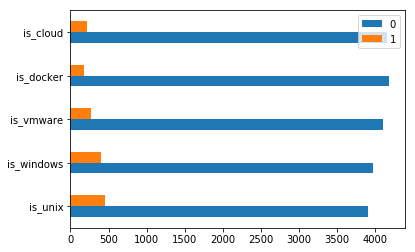

In [13]:
d = {}
for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows',),
        'vmware': ('VMWare',),
        'docker': ('Docker / Containers',),
        'cloud': ('Azure', 'Amazon Web Services'),
    }.items():
    d['is_{}'.format(key)] = df['Tecnologías que utilizás'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

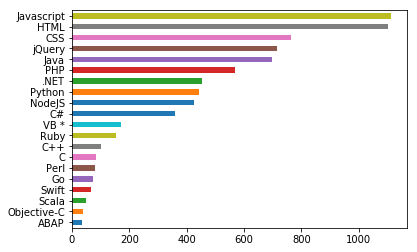

In [14]:
tech_count = {}
for x in pd.concat((df['Tecnologías que utilizás.1'], df['Tecnologías que utilizás.2'])).dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(20).plot.barh();

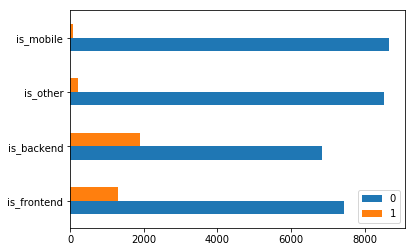

In [15]:
d = {}
for key, tech in {
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'other': ('VB*', 'C++', 'C,', 'ABAP'),
        'mobile': ('Swift', 'Objective-C')
    }.items():
    d['is_{}'.format(key)] = pd.concat((df['Tecnologías que utilizás.1'], df['Tecnologías que utilizás.2'])).apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

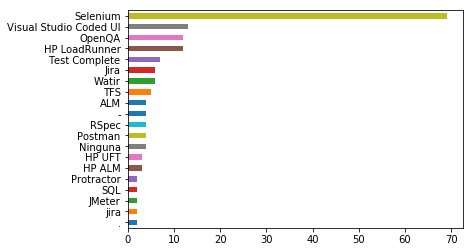

In [16]:
tech_count = {}
for x in df['Tecnologías que utilizás.3'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(20).plot.barh();

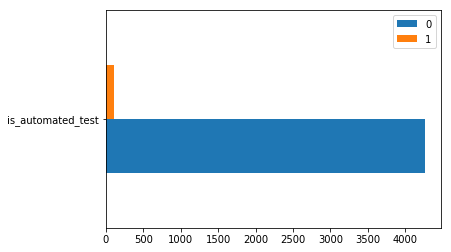

In [17]:
d = {}
for key, tech in {
        'automated_test': ('Selenium', 'Visual Studio Coded UI', 'OpenQA', 'HP LoadRunner', 'Test Complete', 'Watir', 'Postman', 'RSpec', 'JMeter'),
    }.items():
    d['is_{}'.format(key)] = df['Tecnologías que utilizás.3'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

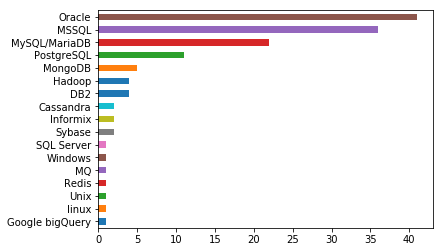

In [18]:
tech_count = {}
for x in df['Tecnologías que utilizás.4'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(20).plot.barh();

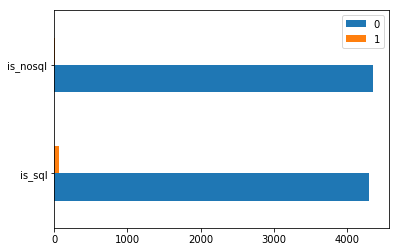

In [19]:
d = {}
for key, tech in {
        'sql': ('Oracle', 'MSSQL', 'MySQL', 'MariaDB', 'PostgreSQL', 'SQL'),
        'nosql': ('Redis', 'MongoDB', 'Hadoop', 'Cassandra', 'Google bigQuery'),
    }.items():
    d['is_{}'.format(key)] = df['Tecnologías que utilizás.4'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

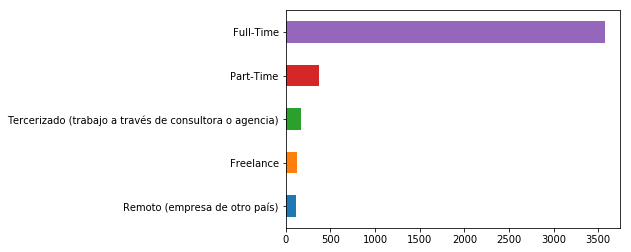

In [20]:
df['Tipo de contrato'].value_counts(ascending=True).plot.barh();

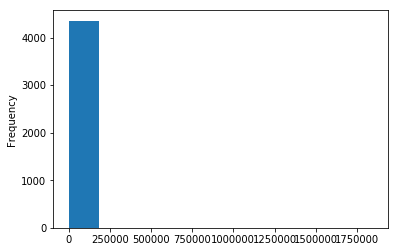

In [21]:
df['Salario mensual (en tu moneda local)'].plot.hist();

Usamos `hist` en vez de `barh` para que agrupe automáticamente en grupos. Parecen haber unos pocos valores muy altos que queremos excluir porque parecen falsos o al menos casos muy específicos que no queremos considerar.

In [22]:
df['Salario mensual (en tu moneda local)'].sort_values(ascending=True).tail(10)

1613     200000.0
2907     280000.0
4310     450000.0
496      460000.0
3785     480000.0
1619     650000.0
4121     800000.0
6        808765.0
1012    1296000.0
3746    1847224.0
Name: Salario mensual (en tu moneda local), dtype: float64

In [23]:
df['Salario mensual (en tu moneda local)'].sort_values(ascending=True).head(10)

4106    1.0
3556    1.0
2818    1.0
2774    2.0
2832    2.7
2773    4.0
1424    8.0
3596    8.0
3394    8.0
3551    8.0
Name: Salario mensual (en tu moneda local), dtype: float64

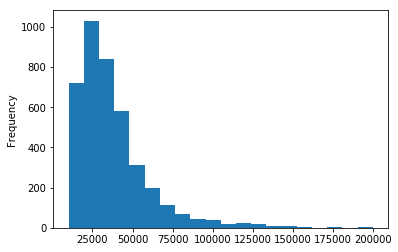

In [24]:
salary = df['Salario mensual (en tu moneda local)']
salary = salary[salary <= 200000]
salary = salary[salary > 10000]
salary.plot.hist(bins=20);

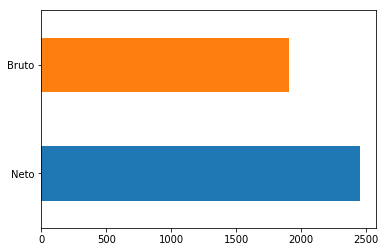

In [25]:
df['¿Bruto o neto?'].value_counts().plot.barh();

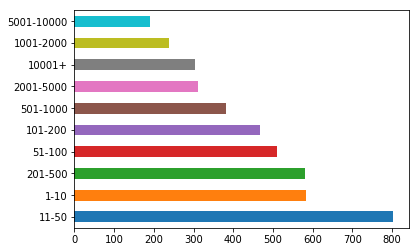

In [26]:
df['Cantidad de empleados'].value_counts().plot.barh();

Hasta acá vimos los datos que tenemos disponibles para usar en el modelo. El objetivo del modelo es predecir el salario de una persona sabiendo sólo cómo habría respondido a todas las preguntas de la encuesta, excepto el sueldo.

Un primer modelo que podemos armar usando menos información que toda la disponible es un modelo linear que sólo considera la experiencia. Intuitivamente uno puede pensar que más años de experiencia resultarían en un salario mayor. Veamos la relación entre estas dos variables.

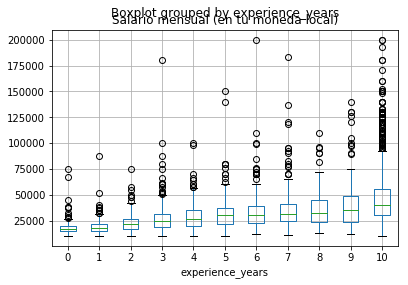

In [27]:
def experience_years(y):
    return {
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        '6': 6,
        '7': 7,
        '8': 8,
        '9': 9,
        '10+': 10,
        'Menos de un año': 0,
    }[y]
df_filtered_years = df[df['Salario mensual (en tu moneda local)'] <= 200000]
df_filtered_years = df_filtered_years[df_filtered_years['Salario mensual (en tu moneda local)'] > 10000]
df_filtered_years['experience_years'] = df_filtered_years['Años de experiencia'].apply(experience_years)
df_filtered_years.boxplot('Salario mensual (en tu moneda local)', 'experience_years');

Efectivamente los sueldos medios (la línea verde) suelen subir con los años de experiencia. También vemos que la variabilidad es mayor (el tamaño de la caja y las líneas superiores e inferiores están más separadas).

In [28]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(df_filtered_years[['experience_years']], df_filtered_years['Salario mensual (en tu moneda local)'])
print('Pendiente: {}\nOrdenada al origen: {}'.format(lr.coef_[0], lr.intercept_))

Pendiente: 2822.1378557159946
Ordenada al origen: 17705.819551187513


Sólo considerando la experiencia, vemos que una persona inicialmente cobra 17.705 pesos y cada año de experiencia suma 2.822 pesos hasta un máximo de 45.926 a los 10 o más años de experiencia que es el máximo de la encuesta.

Esta primera aproximación es intuitiva y fácil de ver. Podemos generalizar la solución de usar una recta a más de una variable a la vez, pero ese caso ya no podemos graficarlo. Para llegar a eso necesitamos transformar todos los valores que graficamos anteriormente en valores numéricos.

Para preparar los valores a veces es evidente qué números usar, para otros no tanto. Vamos a ver uno por uno qué hacer. En caso de sexo, hay tres opciones, pero las respuestas de "Otros" son muy pocas. Para agrupar más los resultados vamos a juntarlos con mujeres. Una vez que tenemos dos categorías le podemos poner valores 0 y 1 sin problema.

A la edad vamos a ponere el valor promedio de cada segmento. Para menos de 18 elijo 17 y mayores de 50, 57 de formar arbitraria, no necesariamente son los mejores valores para ponerle.

Para la provincia vemos que hay muchas respuestas en CABA, GBA, PBA, Córdoba y Santa Fe, y después baja bastante siguiendo la cantidad de población. Para esto asignarle un valor numérico a cada provincia (1 CABA, 2 PBA, 3 GBA, 4 Mendoza, 5 Salta, etc) resultaría poco útil porque el modelo las agruparía de forma arbitraria y sin sentido. Para ello podemos en cambio crear una columna para cada provincia, pero como la mayoría de las provincias tienen pocos datos y eso no le ayuda al modelo a aprender bien, sólo vamos a usar las más pobladas.

Para la cantidad de gente a cargo, si bien es un número, una transformación puede ayudar. Estar a cargo de 0 personas o de 2 es bastante más diferente que estar a cargo de 100 o 102. Para esto una transformación logarítmica nos ayuda.

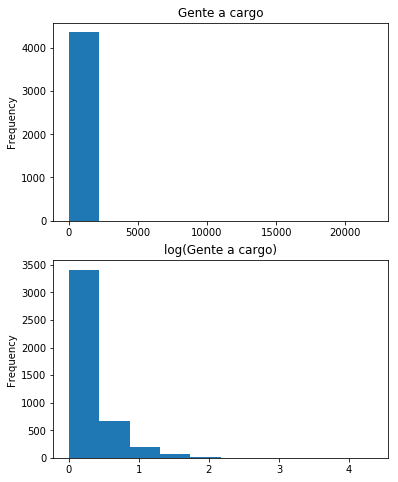

In [29]:
import matplotlib.pyplot as plt
from math import log
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
df['¿Cuánta?'].plot.hist(title='Gente a cargo', ax=ax1)
df['¿Cuánta?'].apply(lambda x: log(x+1, 10)).plot.hist(title='log(Gente a cargo)', ax=ax2);

El nivel de estudio también es complicado de comprender. Se puede considerar que hay una escala ordinal (no como las provincias) por lo que abrirlo en distintas columnas no parece lo mejor.

Se espera que Primario < Secundario < Terciario < Universitario < Posgrado < Doctorado y que Incompleto < En Curso < Completo.
Sin embargo debería ser mejor tener Terciario Completo que Univesitario Incompleto. 

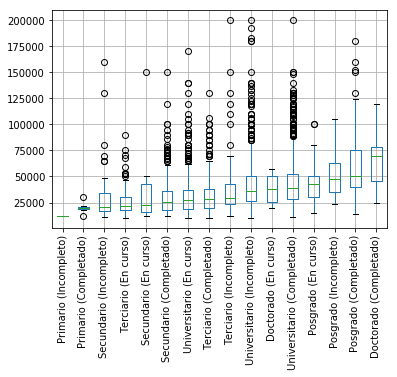

In [30]:
df_filtered_years['study'] = df_filtered_years.apply(lambda x: '{} ({})'.format(x['Nivel de estudios alcanzado'], x['Estado']), axis=1)
# https://stackoverflow.com/a/37871635
def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  return df2[meds.index].boxplot(rot=90)
boxplot_sorted(df_filtered_years, 'study', 'Salario mensual (en tu moneda local)');

In [31]:
df_filtered_years.groupby('study')['Salario mensual (en tu moneda local)'].median().sort_values()

study
Primario (Incompleto)         12000.0
Primario (Completado)         19500.0
Secundario (Incompleto)       21000.0
Terciario (En curso)          21935.0
Secundario (En curso)         22800.0
Secundario (Completado)       25762.5
Universitario (En curso)      27000.0
Terciario (Completado)        28000.0
Terciario (Incompleto)        29325.0
Universitario (Incompleto)    36000.0
Doctorado (En curso)          37873.5
Universitario (Completado)    39350.0
Posgrado (En curso)           42500.0
Posgrado (Incompleto)         48000.0
Posgrado (Completado)         50000.0
Doctorado (Completado)        69500.0
Name: Salario mensual (en tu moneda local), dtype: float64

Los números muestran más o menos lo esperado, salvo algunas anomalías como "Terciario (En curso)" inferior a "Secundario (En curso)". Algunas otras son quizás explicables por otras columnas que tenemos, por ejemplo "Universitario (Incompleto)" mayor a "Universitario (En curso)" porque puede agarrar el primero gente con más experiencia o edad.

Una cosa que vale la pena ver es cuánto y si afecta la cantidad de empleados de la empresa al sueldo.

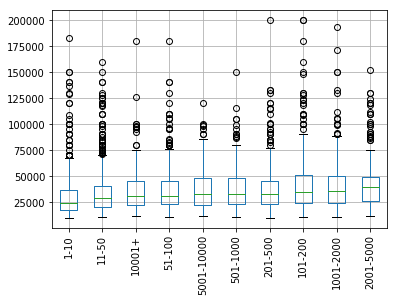

In [32]:
boxplot_sorted(df_filtered_years, 'Cantidad de empleados', 'Salario mensual (en tu moneda local)');

In [33]:
df_filtered_years.groupby('Cantidad de empleados')['Salario mensual (en tu moneda local)'].median().sort_values()

Cantidad de empleados
1-10          24000.0
11-50         29000.0
10001+        31000.0
51-100        31300.0
5001-10000    32500.0
501-1000      33000.0
201-500       33200.0
101-200       34750.0
1001-2000     36000.0
2001-5000     39500.0
Name: Salario mensual (en tu moneda local), dtype: float64

Parece verse que las empresas pequeñas pagan menos mientras que las más grandes no muestran un patrón claro. Vamos a dividir sólo en su trabaja en una empresa pequeña o no.

In [34]:
df_filtered = df[df['Salario mensual (en tu moneda local)'] <= 200000]
df_filtered = df_filtered[df_filtered['Salario mensual (en tu moneda local)'] > 10000]
df_filtered = df_filtered[df_filtered['¿Bruto o neto?'] == 'Bruto']
df_filtered = df_filtered[df_filtered['Tipo de contrato'] == 'Full-Time']

In [35]:
def transform_row(row):
    d = {}
    all_techs = ','.join((
        str(row['Tecnologías que utilizás']),
        str(row['Tecnologías que utilizás.1']),
        str(row['Tecnologías que utilizás.2']),
        str(row['Tecnologías que utilizás.3']),
        str(row['Tecnologías que utilizás.4']),
    ))
    for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows',),
        'vmware': ('VMWare',),
        'docker': ('Docker / Containers',),
        'cloud': ('Azure', 'Amazon Web Services'),
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'lowlevelstuff': ('VB*', 'C++', 'C,', 'ABAP'),
        'mobile': ('Swift', 'Objective-C'),
        'automated_test': ('Selenium', 'Visual Studio Coded UI', 'OpenQA', 'HP LoadRunner', 'Test Complete', 'Watir', 'Postman', 'RSpec', 'JMeter'),
        'sql': ('Oracle', 'MSSQL', 'MySQL', 'MariaDB', 'PostgreSQL', 'SQL'),
        'nosql': ('Redis', 'MongoDB', 'Hadoop', 'Cassandra', 'Google bigQuery'),
    }.items():
        d['is_{}'.format(key)] = int(any(map(lambda t: t in all_techs, tech)))
    d.update({
        'is_male': int(row['Me identifico'] == 'Hombre'),
        'age': {
            '27 - 30': 28.5,
            '31 - 33': 32,
            '34 - 36': 35,
            '37 - 40': 38.5,
            '24 - 26': 25,
            '21 - 23': 22,
            '41 - 45': 43,
            '46 - 49': 48.5,
            '50+': 57,
            '18 - 20': 19,
            'Menos de 18 años': 17,
        }[row['Tengo']],
        'is_caba': int(row['Argentina'] == 'Ciudad Autónoma de Buenos Aires'),
        'is_gba': int(row['Argentina'] == 'GBA'),
        'is_pba': int(row['Argentina'] == 'Provincia de Buenos Aires'),
        'is_cba': int(row['Argentina'] == 'Córdoba'),
        'is_santafe': int(row['Argentina'] == 'Santa Fe'),
        'experience_years': experience_years(row['Años de experiencia']),
        'current_position_years': experience_years(row['Años en el puesto actual']),
        'log_in_charge_of': log(int(row['¿Cuánta?']) + 1, 10),
        'study': {
            'Primario (Incompleto)': 0,
            'Primario (En curso)': 0,
            'Primario (Completado)':1,
            'Secundario (Incompleto)': 2,
            'Secundario (En curso)': 3,
            'Secundario (Completado)': 4,
            'Terciario (Incompleto)': 5,
            'Terciario (En curso)': 5,
            'Universitario (En curso)': 5,
            'Universitario (Incompleto)': 5,
            'Terciario (Completado)': 6,
            'Universitario (Completado)': 7,
            'Doctorado (En curso)': 7,
            'Posgrado (En curso)': 7,
            'Posgrado (Incompleto)': 7,
            'Doctorado (Incompleto)': 7,
            'Posgrado (Completado)': 8,
            'Doctorado (Completado)': 9,
        }['{} ({})'.format(row['Nivel de estudios alcanzado'], row['Estado'])],
        'is_computer_degree': is_desistemas(row['Carrera']),
        'is_developer': int(row['Trabajo de'] == 'Developer'),
        'is_sysadmin': int(row['Trabajo de'] == 'SysAdmin / DevOps'),
        'is_startup': int(row['Cantidad de empleados'] in ('1-10', '11-50')),
    })
    if 'Salario mensual (en tu moneda local)' in row:
        d['salary'] = int(row['Salario mensual (en tu moneda local)'])
    return d

df_ready = df_filtered.apply(transform_row, axis=1, result_type='expand')
df_ready

,age,current_position_years,experience_years,is_automated_test,is_backend,is_caba,is_cba,is_cloud,is_computer_degree,is_developer,...,is_santafe,is_sql,is_startup,is_sysadmin,is_unix,is_vmware,is_windows,log_in_charge_of,salary,study
7,35.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20770.0,5.0
10,32.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,17220.0,5.0
15,35.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,18000.0,4.0
17,28.5,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,18000.0,7.0
24,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,15000.0,5.0
30,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,22000.0,5.0
31,25.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,30000.0,5.0
38,38.5,3.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.477121,49000.0,5.0
40,25.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,20484.0,5.0
41,28.5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,17000.0,5.0


Ahora podemos calcular la regresión lineal con todas las columnas a la vez.

In [36]:
X, y = df_ready.drop('salary', axis=1), df_ready['salary']
lr = LinearRegression().fit(X, y)
for i, col in enumerate(X.columns):
    print('{: <40} | {:,}'.format(col, int(lr.coef_[i])))

age                                      | 151
current_position_years                   | -685
experience_years                         | 2,434
is_automated_test                        | -4,047
is_backend                               | 6,029
is_caba                                  | 15,706
is_cba                                   | 3,886
is_cloud                                 | 5,164
is_computer_degree                       | 1,250
is_developer                             | 2,532
is_docker                                | 2,765
is_frontend                              | -5,132
is_gba                                   | 8,385
is_lowlevelstuff                         | 986
is_male                                  | 9,019
is_mobile                                | 5,226
is_nosql                                 | -4,841
is_pba                                   | 7,769
is_santafe                               | 5,669
is_sql                                   | -2,011
is_startup          

Este analisis nos sirve para ver qué variables son más significativas para ver el salario de una persona en nuestro grupo (la cantidad de personas a cargo, si está en Capital Federal) y menos significativas (la edad, los años en la posición actual). Los valores positivos son caracteristicas que suman al sueldo mientras los negativos restan.

Lamentablemente ser hombre parece sumar bastante.

Mobile paga más que backend, y frontend tiene un valor negativo. El valor negativo, de todas formas, debe entenderse como negativo respecto a las personas que no especificaron ninguna tecnología que probablemente sea una mezcla entretodos los grupos.

Ahora que tenemos el regresor, podemos ver cómo se comportaría con datos desconocidos. Para eso podemos imaginar a Alicia, una sysadmin de Entre Ríos que tiene 28 años, 7 de experiencia, acaba de empezar a trabajar en una startup usando docker y aws, no estudió en la universidad ni terciario. También tenemos a Roberto de Capital, 35 años, 12 de experiencia, con un Posgrado en Informática, a cargo de un equipo de 100 personas en una empresa de 2000.

In [37]:
alice = {
    'Me identifico': 'Mujer',
    'Tengo': '27 - 30',
    'Argentina': 'Entre Ríos',
    'Años de experiencia': '7',
    'Años en el puesto actual': 'Menos de un año',
    '¿Gente a cargo?': 'No',
    '¿Cuánta?': '0',
    'Nivel de estudios alcanzado': 'Secundario',
    'Estado': 'Completado',
    'Carrera': '',
    'Realizaste cursos de especialización': 'No',
    'Trabajo de': 'SysAdmin / DevOps',
    'Tecnologías que utilizás': 'Amazon Web Services, Docker / Containers',
    'Tecnologías que utilizás.1': '',
    'Tecnologías que utilizás.2': '',
    'Automation o funcional?': '',
    'Tecnologías que utilizás.3': '',
    'Tecnologías que utilizás.4': '',
    'Tipo de contrato': 'Full-Time',
    'Cantidad de empleados': '1-10',
}
alice_transformed = transform_row(alice)
int(lr.predict([[alice_transformed[col] for col in X.columns]])[0])

22743

In [38]:
bob = {
    'Me identifico': 'Hombre',
    'Tengo': '34 - 36',
    'Argentina': 'Ciudad Autónoma de Buenos Aires',
    'Años de experiencia': '10+',
    'Años en el puesto actual': '10+',
    '¿Gente a cargo?': 'Sí',
    '¿Cuánta?': '100',
    'Nivel de estudios alcanzado': 'Doctorado',
    'Estado': 'Completado',
    'Carrera': 'Licenciatura en Informática',
    'Realizaste cursos de especialización': 'No',
    'Trabajo de': 'Developer',
    'Tecnologías que utilizás': '',
    'Tecnologías que utilizás.1': '',
    'Tecnologías que utilizás.2': '',
    'Automation o funcional?': '',
    'Tecnologías que utilizás.3': '',
    'Tecnologías que utilizás.4': '',
    'Tipo de contrato': 'Full-Time',
    'Cantidad de empleados': '1001-2000',
}
bob_transformed = transform_row(bob)
int(lr.predict([[bob_transformed[col] for col in X.columns]])[0])

96638

Ya tenemos un modelo posible, veamos otra posibilidad. Lo que una persona suele hacer cuando quiere responder esta pregunta es buscar gente que haya respondido la encuesta con respuestas similares a las de Alice y Bob de nuestros ejemplos y eso nos va a dar una idea de cuánto pueden ganar ellos. Este tipo de modelos se llama kNN: k nearest neighbours, busca los _k_ valores más cercanos al que queremos encontrar y con ellos calcula el valor objetivo.

In [39]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor().fit(X, y)

In [40]:
int(knnr.predict([[alice_transformed[col] for col in X.columns]])[0])

52800

In [41]:
int(knnr.predict([[bob_transformed[col] for col in X.columns]])[0])

44040

¡Epa! Alicia parece estar ganando más que Roberto, lo cual es sorprendente. Veamos qué registros parecidos encontró en cada caso.

In [42]:
alice_transformed

{'is_unix': 0,
 'is_windows': 0,
 'is_vmware': 0,
 'is_docker': 1,
 'is_cloud': 1,
 'is_frontend': 0,
 'is_backend': 0,
 'is_lowlevelstuff': 0,
 'is_mobile': 0,
 'is_automated_test': 0,
 'is_sql': 0,
 'is_nosql': 0,
 'is_male': 0,
 'age': 28.5,
 'is_caba': 0,
 'is_gba': 0,
 'is_pba': 0,
 'is_cba': 0,
 'is_santafe': 0,
 'experience_years': 7,
 'current_position_years': 0,
 'log_in_charge_of': 0.0,
 'study': 4,
 'is_computer_degree': 0,
 'is_developer': 0,
 'is_sysadmin': 1,
 'is_startup': 1}

In [43]:
neighbours = knnr.kneighbors([[alice_transformed[col] for col in X.columns]])[1]
X.iloc[neighbours[0]]

,age,current_position_years,experience_years,is_automated_test,is_backend,is_caba,is_cba,is_cloud,is_computer_degree,is_developer,...,is_pba,is_santafe,is_sql,is_startup,is_sysadmin,is_unix,is_vmware,is_windows,log_in_charge_of,study
224,28.5,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,5.0
1372,28.5,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,4.0
322,28.5,0.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,4.0
2164,28.5,1.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60206,5.0
1113,28.5,0.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.00000,5.0


In [44]:
bob_transformed

{'is_unix': 0,
 'is_windows': 0,
 'is_vmware': 0,
 'is_docker': 0,
 'is_cloud': 0,
 'is_frontend': 0,
 'is_backend': 0,
 'is_lowlevelstuff': 0,
 'is_mobile': 0,
 'is_automated_test': 0,
 'is_sql': 0,
 'is_nosql': 0,
 'is_male': 1,
 'age': 35,
 'is_caba': 1,
 'is_gba': 0,
 'is_pba': 0,
 'is_cba': 0,
 'is_santafe': 0,
 'experience_years': 10,
 'current_position_years': 10,
 'log_in_charge_of': 2.0043213737826426,
 'study': 9,
 'is_computer_degree': 1,
 'is_developer': 1,
 'is_sysadmin': 0,
 'is_startup': 0}

In [45]:
neighbours = knnr.kneighbors([[bob_transformed[col] for col in X.columns]])[1]
X.iloc[neighbours[0]]

,age,current_position_years,experience_years,is_automated_test,is_backend,is_caba,is_cba,is_cloud,is_computer_degree,is_developer,...,is_pba,is_santafe,is_sql,is_startup,is_sysadmin,is_unix,is_vmware,is_windows,log_in_charge_of,study
166,35.0,10.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.698970,7.0
1422,35.0,10.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.698970,7.0
1788,35.0,9.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.0
2654,35.0,10.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845098,7.0
888,35.0,10.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.0


Vemos una de las personas parecidas a Bob que vive en Córdoba, que no es developer y otras que no tienen gente a cargo. El problema es que no consideramos normalizar los datos.

Entre alguien que es idéntico a Bob pero no tiene gente a cargo comparado con otro clon de Bob pero que no hizo un posgrado ni doctorado, ¿quién es más parecido a Bob de ambos? Es difícil saberlo a priori. El modelo, ahora mismo, considera igual de dispar una unidad en cualquiera de las columnas, o sea que hay tanta distancia de Primario Incompleto (0) a Doctorado Completo (9) como de tener 25 años a 34. De la misma forma es la misma la distancia entre tener 30 años y 31 como de estar a cargo de 0 personas o 10 personas.

Lo que podemos hacer para darle una escala de importancia a la distancia entre dos puntos en cada columna es usar los coeficientes de la regresión lineal. Entonces multiplicamos cada columna por su coeficiente y una persona que está en CABA está a 15706 unidades de alguien que no, mientras que cinco años de diferencia entre dos personas representan 755 unidades.

Esta forma de calcular distancias no es estándar sino algo que estoy inventado, no necesariamente va a funcionar ien pero veamos.

In [46]:
df_ready_normalized = df_ready.copy()
for i, col in enumerate([col for col in df_ready.columns if col != 'salary']):
    df_ready_normalized[col] *= lr.coef_[i]

def normalize_row(transformed_row):
    return [transformed_row[col] * lr.coef_[i] for i, col in enumerate([col for col in df_ready.columns if col != 'salary'])]

X, y = df_ready_normalized.drop('salary', axis=1), df_ready_normalized['salary']
knnr2 = KNeighborsRegressor().fit(X, y)

In [47]:
int(knnr2.predict([normalize_row(alice_transformed)]))

16800

In [48]:
int(knnr2.predict([normalize_row(bob_transformed)]))

95000

Estos valores son más parecidos a los anteriores y menos sorpresivo. Veamos los registros parecidos a Alice y Bob en este caso.

In [49]:
def unnormalize_row(normalized_row):
    return {col: normalized_row[col] / lr.coef_[i] for i, col in enumerate([col for col in df_ready.columns if col != 'salary'])}

In [50]:
neighbours = knnr2.kneighbors([normalize_row(alice_transformed)])[1]
X.iloc[neighbours[0]].apply(unnormalize_row, axis=1, result_type='expand')

,age,current_position_years,experience_years,is_automated_test,is_backend,is_caba,is_cba,is_cloud,is_computer_degree,is_developer,...,is_pba,is_santafe,is_sql,is_startup,is_sysadmin,is_unix,is_vmware,is_windows,log_in_charge_of,study
3614,35.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,5.0
15,35.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,4.0
2641,35.0,2.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,6.0
3273,25.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,5.0
3293,28.5,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30103,5.0


In [51]:
neighbours = knnr2.kneighbors([normalize_row(bob_transformed)])[1]
X.iloc[neighbours[0]].apply(unnormalize_row, axis=1, result_type='expand')

,age,current_position_years,experience_years,is_automated_test,is_backend,is_caba,is_cba,is_cloud,is_computer_degree,is_developer,...,is_pba,is_santafe,is_sql,is_startup,is_sysadmin,is_unix,is_vmware,is_windows,log_in_charge_of,study
2118,43.0,10.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.785330,7.0
1445,38.5,0.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.004321,7.0
1826,38.5,10.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.414973,8.0
2298,28.5,2.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.491362,8.0
1749,38.5,2.0,10.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.568202,7.0


Vemos ahora sí que hay más variabilidad en columnas poco significativas (`age`, `current_position_years`) y menos en las que consideramos más importantes (`log_in_charge_of`, `is_caba`).

Ahora tenemos dos modelos que predicen, ¿cómo podemos saber cuál es mejor? Hay un coeficiente que se llama R² que da un número no mayor a 1 que evalúa un regresor, siendo 1 el mayor valor posible. Veamos el puntaje de nuestros regresores.

In [52]:
knnr2.score(df_ready_normalized.drop('salary', axis=1), df_ready_normalized['salary'])

0.5738108606868361

In [53]:
lr.score(df_ready.drop('salary', axis=1), df_ready['salary'])

0.4266359252844426

Como esperabamos, k nearest neighbors da mejores resultados que la regresión lineal. Sin embargo la forma de evaluarlos es estadísticamente poco confiable porque estamos testeando los mismos datos que usamos para entrenar. Lo que tenemos que hacer en realidad es dividir nuestros datos, usar unos para entrenar y los otros para testear, así veremos cuán bien puede el regresor predecir valores desconocidos.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_ready_normalized.drop('salary', axis=1),
    df_ready_normalized['salary'],
    test_size=0.2,
    random_state=0
)
KNeighborsRegressor().fit(X_train, y_train).score(X_test, y_test)

0.23005695518617963

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_ready.drop('salary', axis=1),
    df_ready['salary'],
    test_size=0.2,
    random_state=0
)
LinearRegression().fit(X_train, y_train).score(X_test, y_test)

0.368047382814798

Ahora vemos que en realidad la regresión linear es mejor prediciendo resultados. Sin embargo no descartemos a knn todavía. La _k_ significa cuántos vecinos cercanos queremos considerar. Un valor de _k_ muy bajo es demasiado sensible a cada respuesta, mientras que uno demasiado alto terminaría no considerando los parámetros adecuadamente. Por defecto el regresor usa 5, pero no necesariamente ése es el mejor valor. No existe un valor que sea mejor en todas las condiciones, depende de la cantidad de registros, la cantidad de columnas y la distribución de ellas. Lo que podemos hacer es probar varios valores de _k_ hasta encontrar el que dé un mejor resultado.

In [56]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf = KNeighborsRegressor()
param_dist = {"n_neighbors": sp_randint(1, 1000)}
n_iter_search = 100

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=0)
random_search.fit(df_ready_normalized.drop('salary', axis=1), df_ready_normalized['salary'])

import numpy as np
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-zK59MtF0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.302 (std: 0.111)
Parameters: {'n_neighbors': 29}



In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_ready_normalized.drop('salary', axis=1),
    df_ready_normalized['salary'],
    test_size=0.2,
    random_state=0
)
KNeighborsRegressor(n_neighbors=25).fit(X_train, y_train).score(X_test, y_test)

0.2931991849038361

In [58]:
knn = KNeighborsRegressor(n_neighbors=25).fit(df_ready_normalized.drop('salary', axis=1), df_ready_normalized['salary'])

In [59]:
int(knn.predict([normalize_row(alice_transformed)]))

26526

In [60]:
int(knn.predict([normalize_row(bob_transformed)]))

92267

Vemos que efectivamente el puntaje mejora considerando más valores cercanos aunque sigue siendo peor que el modelo de regresión lineal.

Ahora veamos otro modelo más complejo llamado Random Forest. Lo que este modelo hace es armar varios árboles de decisión donde cada rama se divide de acuerdo a una columna. Crearemos primero uno muy sencillo para ver su funcionamiento. Este bosque va a tener sólo dos árboles de hasta dos bifurcaciones cada uno para poder verlo gráficamente.

Para este modelo no es necesario normalizar los valores porque sólamente toma divisiones de mayor o menor a un valor, por lo que cualquier cambio que mantenga el orden es indiferente.

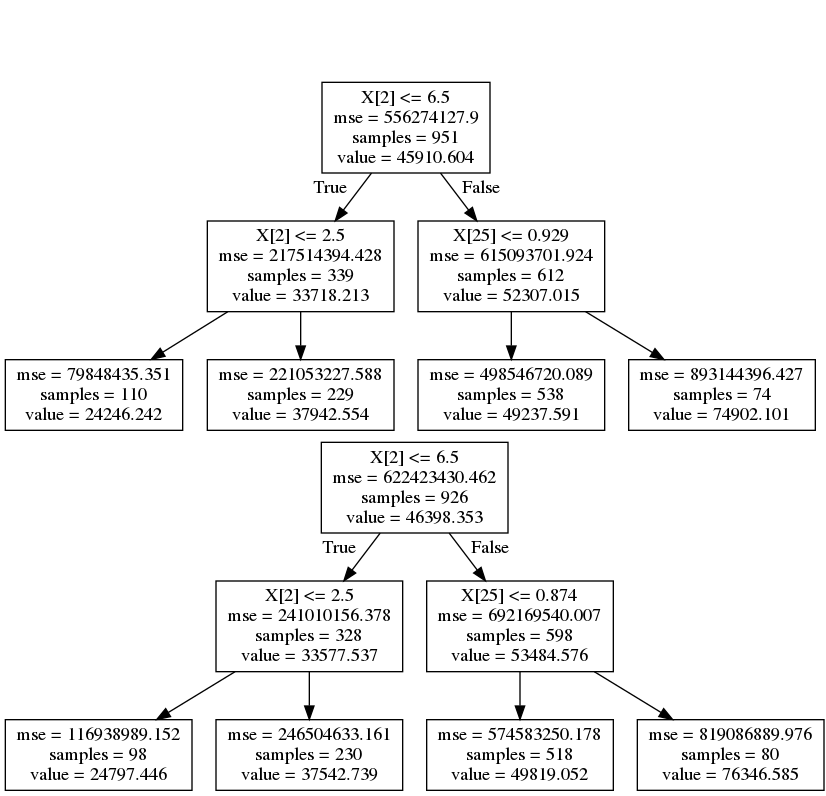

In [61]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(
    random_state=0,
    n_estimators=2,
    max_depth=2
).fit(df_ready.drop('salary', axis=1), df_ready['salary'])

import os
import subprocess
from sklearn.tree import export_graphviz

export_graphviz(rfr.estimators_[0], '/tmp/tree0.dot')
subprocess.check_call('dot -Tpng /tmp/tree0.dot -o /tmp/tree0.png', shell=True)
export_graphviz(rfr.estimators_[1], '/tmp/tree1.dot')
subprocess.check_call('dot -Tpng /tmp/tree1.dot -o /tmp/tree1.png', shell=True)

from matplotlib.pyplot import imshow
from PIL import Image

plt.figure(1, (14, 14))
plt.axis('off')
pil_im = Image.open('/tmp/tree0.png', 'r')
plt.figimage(np.asarray(pil_im), 0, 360, cmap='gray')
os.unlink('/tmp/tree0.dot')
os.unlink('/tmp/tree0.png')
pil_im = Image.open('/tmp/tree1.png', 'r')
plt.figimage(np.asarray(pil_im), 0, 0, cmap='gray')
os.unlink('/tmp/tree1.dot')
os.unlink('/tmp/tree1.png')

In [62]:
df_ready.columns[2], df_ready.columns[25]

('experience_years', 'log_in_charge_of')

En estos gráficos se pueden ver los dos árboles generados. El primer árbol evalúa `X[2]` (años de experiencia) y si es menor a 6.5 sigue para la izquierda, sino para la derecha. En el caso de ser menor se fija si es menor a 2.5 y si es menor se queda con el valor 24246.242. En caso de tener más experiencia se fija `X[25]`, si tiene una gran cantidad de personas a cargo. Intuitivamente esto tiene sentido, para las personas que tienen más de 7 años en la industria un gran diferencial es el de liderazgo, mientras que para gente con menos experiencia cambia más cuánta experiencia tienen, es decir que después de 7 años, la diferencia de experiencia es menos importante.

El segundo árbol de decisión es parecido al primero de decisión 

En el caso de Alice, en ambos árboles empezaría con más de 6.5 años de experiencia y en la segunda división no tiene gente a cargo. Entonces su sueldo sería el promedio entre 49237.591 y 49819.052 según este modelo.

In [63]:
int(rfr.predict([[alice_transformed[col] for col in X.columns]])[0])

49528

Ahora que tenemos una mejor idea intuitiva sobre cómo funciona este modelo, veamos cuáles son los parámetros óptimos para entrenarlo y si podemos superar el puntaje de la regresión lineal.

In [64]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestRegressor(random_state=0)
param_dist = {
    "max_depth": sp_randint(1, 100),
    "n_estimators": sp_randint(1, 100),
    "max_features": sp_randint(1, len(df_ready.columns)),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "bootstrap": [True, False],
}

n_iter_search = 200

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=0)
random_search.fit(df_ready.drop('salary', axis=1), df_ready['salary'])

import numpy as np
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, 1)

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-zK59MtF0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.367 (std: 0.034)
Parameters: {'bootstrap': True, 'max_depth': 22, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 45}



/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-zK59MtF0/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ready.drop('salary', axis=1),
    df_ready['salary'],
    test_size=0.2,
    random_state=0
)

RandomForestRegressor(
    random_state=0,
    n_estimators=45,
    max_depth=22,
    max_features=3,
    bootstrap=True,
    min_samples_leaf=1,
    min_samples_split=12,
).fit(X_train, y_train).score(X_test, y_test)

0.3922790131927095

Lo logramos :). ¡Estamos usando 45 árboles de hasta 22 divisiones!

Veamos ahora según este modelo cómo les va a Alicia y Roberto.

In [66]:
rfr = RandomForestRegressor(
    random_state=0,
    n_estimators=45,
    max_depth=22,
    max_features=3,
    bootstrap=True,
    min_samples_leaf=1,
    min_samples_split=12,
).fit(df_ready.drop('salary', axis=1), df_ready['salary'])

In [67]:
int(rfr.predict([[alice_transformed[col] for col in X.columns]])[0])

40304

In [68]:
int(rfr.predict([[bob_transformed[col] for col in X.columns]])[0])

80249

Si bien tenemos tres modelos y uno de ellos es mejor que los otros, todavía hay formas de mejorarlo. Varias opciones subjetivas fueron incorporadas al preparar los datos, por ejemplo `ABAP` y `C++` fueron agrupados dentro de la misma categoría cuando no son necesariamente iguales. Lo mismo pasa con datos de Jujuy con los de Tierra del Fuego. Agrupar datos nos sirve para tener más valores dentro del mismo grupo, pero también agrupar de más hace perder información en el medio. Quizás se podría probar dividir el país en regiones (Patagonia, Cuyo, Pampa, Noroeste, Mesopotamia, Centro)

Se podría probar distintas opciones de preparación de datos y ver cuál da mejores resultados. La tarea ahora es iterar sobre estos datos para maximizar el puntaje obtenido. A continuación un modelo alternativo similar al anterior.

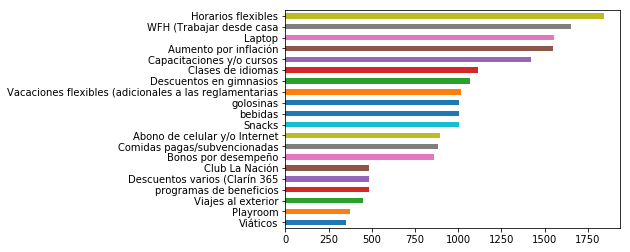

In [69]:
all_benefits = ','.join(df['Beneficios extra'].tolist())
benefits = set(x for x in [item.strip('.,-)()').strip() for s in df['Beneficios extra'].tolist() for item in s.split(',')] if x not in ('', 'a', 'no', 'nada', 'Ninguna', 'etc', 'Ninguna de las anteriores'))
pd.Series({b: all_benefits.count(b) for b in benefits}).sort_values(ascending=True).tail(20).plot.barh();

In [70]:
def transform_row(row):
    d = {}
    all_techs = ','.join((
        str(row['Tecnologías que utilizás']),
        str(row['Tecnologías que utilizás.1']),
        str(row['Tecnologías que utilizás.2']),
        str(row['Tecnologías que utilizás.3']),
        str(row['Tecnologías que utilizás.4']),
    ))
    for key, tech in {
        'linux': ('Linux', ),
        'windows': ('.NET', 'C#', 'Windows',),
        'vmware': ('VMWare',),
        'cloud': ('Azure', 'Amazon Web Services'),
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Python', 'Perl', 'Scala'),
        'mobile': ('Swift', 'Objective-C'),
        'automated_test': ('Selenium', 'Visual Studio Coded UI', 'OpenQA', 'HP LoadRunner', 'Test Complete', 'Watir', 'Postman', 'RSpec', 'JMeter'),
        'sql': ('Oracle', 'MSSQL', 'MySQL', 'MariaDB', 'PostgreSQL', 'SQL'),
        'nosql': ('Redis', 'MongoDB', 'Hadoop', 'Cassandra', 'Google bigQuery'),
    }.items():
        d['is_{}'.format(key)] = int(any(map(lambda t: t in all_techs, tech)))

    d['is_Ciudad Autónoma de Buenos Aires'] = int(row['Argentina'] in ('Ciudad Autónoma de Buenos Aires',))
    d['is_Provincia de Buenos Aires'] = int(row['Argentina'] in ('Provincia de Buenos Aires',))
    d['is_GBA'] = int(row['Argentina'] in ('GBA',))
    d['is_patagonia'] = int(row['Argentina'] in ('Chubut', 'Tierra del Fuego', 'Neuquén', 'Santa Cruz', 'Río Negro'))
    d['is_pampa'] = int(row['Argentina'] in ('Córdoba', 'Santa Fe', 'La Pampa'))
    d['is_cuyo'] = int(row['Argentina'] in ('Mendoza', 'San Luis', 'San Juan'))
    d['is_centro'] = int(row['Argentina'] in ('Chaco', 'Santiago del Estero', 'Formosa'))

    d.update({
        'is_male': int(row['Me identifico'] == 'Hombre'),
        'age': {
            '27 - 30': 28.5,
            '31 - 33': 32,
            '34 - 36': 35,
            '37 - 40': 38.5,
            '24 - 26': 25,
            '21 - 23': 22,
            '41 - 45': 43,
            '46 - 49': 48.5,
            '50+': 57,
            '18 - 20': 19,
            'Menos de 18 años': 17,
        }[row['Tengo']],
        'experience_years': experience_years(row['Años de experiencia']),
        'current_position_years': experience_years(row['Años en el puesto actual']),
        'log_in_charge_of': log(int(row['¿Cuánta?']) + 1, 10),
        'study': {
            'Primario (Incompleto)': 0,
            'Primario (En curso)': 0,
            'Primario (Completado)': 1,
            'Secundario (Incompleto)': 2,
            'Secundario (En curso)': 3,
            'Secundario (Completado)': 4,
            'Terciario (Incompleto)': 5,
            'Terciario (En curso)': 5,
            'Universitario (En curso)': 5,
            'Universitario (Incompleto)': 5,
            'Terciario (Completado)': 6,
            'Universitario (Completado)': 7,
            'Doctorado (En curso)': 7,
            'Posgrado (En curso)': 7,
            'Posgrado (Incompleto)': 7,
            'Doctorado (Incompleto)': 7,
            'Posgrado (Completado)': 8,
            'Doctorado (Completado)': 9,
        }['{} ({})'.format(row['Nivel de estudios alcanzado'], row['Estado'])],
        'is_computer_degree': is_desistemas(row['Carrera']),
        'is_developer': int(row['Trabajo de'] == 'Developer'),
        'is_sysadmin': int(row['Trabajo de'] == 'SysAdmin / DevOps'),
        'is_helpdesk': int(row['Trabajo de'] == 'HelpDesk'),
        'is_networking': int(row['Trabajo de'] == 'Networking'),
        'is_pm': int(row['Trabajo de'] == 'PM'),
        'is_qa': int(row['Trabajo de'] == 'QA / Tester'),
        'is_architect': int(row['Trabajo de'] == 'Architect'),
        'is_designer': int(row['Trabajo de'] == 'Designer'),
        'is_startup': int(row['Cantidad de empleados'] in ('1-10', '11-50')),
        'has_flexible_timing': int('Horarios flexibles' in row['Beneficios extra']),
        'has_wfh': int('WFH' in row['Beneficios extra']),
        'has_laptop': int('Laptop' in row['Beneficios extra']),
        'has_inflation_rise': int('Aumento por inflación' in row['Beneficios extra']),
        'has_capacitation': int('Capacitaciones y/o cursos' in row['Beneficios extra']),
        'has_language_courses': int('Clases de idiomas' in row['Beneficios extra']),
        'has_gym_discount': int('Descuentos en gimnasios' in row['Beneficios extra']),
        'has_snacks': int('snacks' in row['Beneficios extra'].lower()),
        'has_drinks': int('bebidas' in row['Beneficios extra'].lower()),
        'has_candies': int('golosinas' in row['Beneficios extra'].lower()),
        'has_internet': int('Abono de celular y/o Internet' in row['Beneficios extra']),
        'has_food': int('Comidas pagas' in row['Beneficios extra']),
        'has_bonus': int('Bonos por desempeño' in row['Beneficios extra']),
    })
    if 'Salario mensual (en tu moneda local)' in row:
        d['salary'] = int(row['Salario mensual (en tu moneda local)'])
    return d

df_ready = df_filtered.apply(transform_row, axis=1, result_type='expand')

X_train, X_test, y_train, y_test = train_test_split(
    df_ready.drop('salary', axis=1),
    df_ready['salary'],
    test_size=0.2,
    random_state=0
)

# usamos los mismos hiperparámetros que antes, después los buscamos de nuevo para ver los mejores valores posibles
RandomForestRegressor(
    random_state=0,
    n_estimators=45,
    max_depth=22,
    max_features=3,
    bootstrap=True,
    min_samples_leaf=1,
    min_samples_split=12,
).fit(X_train, y_train).score(X_test, y_test)

0.5069287119147549

In [71]:
clf = RandomForestRegressor(random_state=0)
param_dist = {
    "max_depth": sp_randint(1, 100),
    "n_estimators": sp_randint(1, 100),
    "max_features": sp_randint(1, len(df_ready.columns)),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "bootstrap": [True, False],
}
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=0)
random_search.fit(df_ready.drop('salary', axis=1), df_ready['salary'])

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-zK59MtF0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-zK59MtF0/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f74ac603438>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f74ac6035c0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f74ac7d8f60>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f74ac7d3710>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7

In [72]:
params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score'] == 1)[0]]
params

{'bootstrap': True,
 'max_depth': 34,
 'max_features': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 11,
 'n_estimators': 81}

In [73]:
rfr2 = RandomForestRegressor(random_state=0, **params).fit(X_train, y_train)
rfr2.score(X_test, y_test)

0.533600730539088

In [74]:
from sklearn.externals import joblib
joblib.dump(rfr, '../models/rfr.pkl')
joblib.dump(rfr2, '../models/rfr2.pkl')
joblib.dump(lr, '../models/lr.pkl')
joblib.dump(knn, '../models/knn.pkl');

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [99]:
X_train.shape

(1213, 46)

In [132]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

scalar = MinMaxScaler()
X_train_scaled = scalar.fit_transform(X_train)

In [133]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4587635293100544

In [134]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='tanh'),
    Dense(46, activation='tanh'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

-3.9336801101029444

In [136]:
from keras.layers import Dropout

model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='tanh'),
    Dense(46, activation='tanh'),
    Dropout(0.1),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

-3.9344243872623093

In [137]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4555995296167127

In [138]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4623866623358638

In [140]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, batch_size=50, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.48036102776820677

In [141]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, batch_size=50, epochs=2000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4656267903545994

In [142]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, batch_size=100, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4767104776743959

In [143]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, batch_size=20, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4661048364440059

In [144]:
model = Sequential([
    Dense(46, input_dim=46, kernel_initializer='normal', activation='relu'),
    Dense(46, activation='relu'),
    Dense(46, activation='selu'),
    Dropout(0.1),
    Dense(1, kernel_initializer='normal'),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_scaled, y_train.values, batch_size=50, epochs=1000, verbose=0);
r2_score(y_test, model.predict(scalar.transform(X_test)))

0.4781157186661411